<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
 7   carbon_footprint_kg_CO2_ha     28242 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.7+ MB


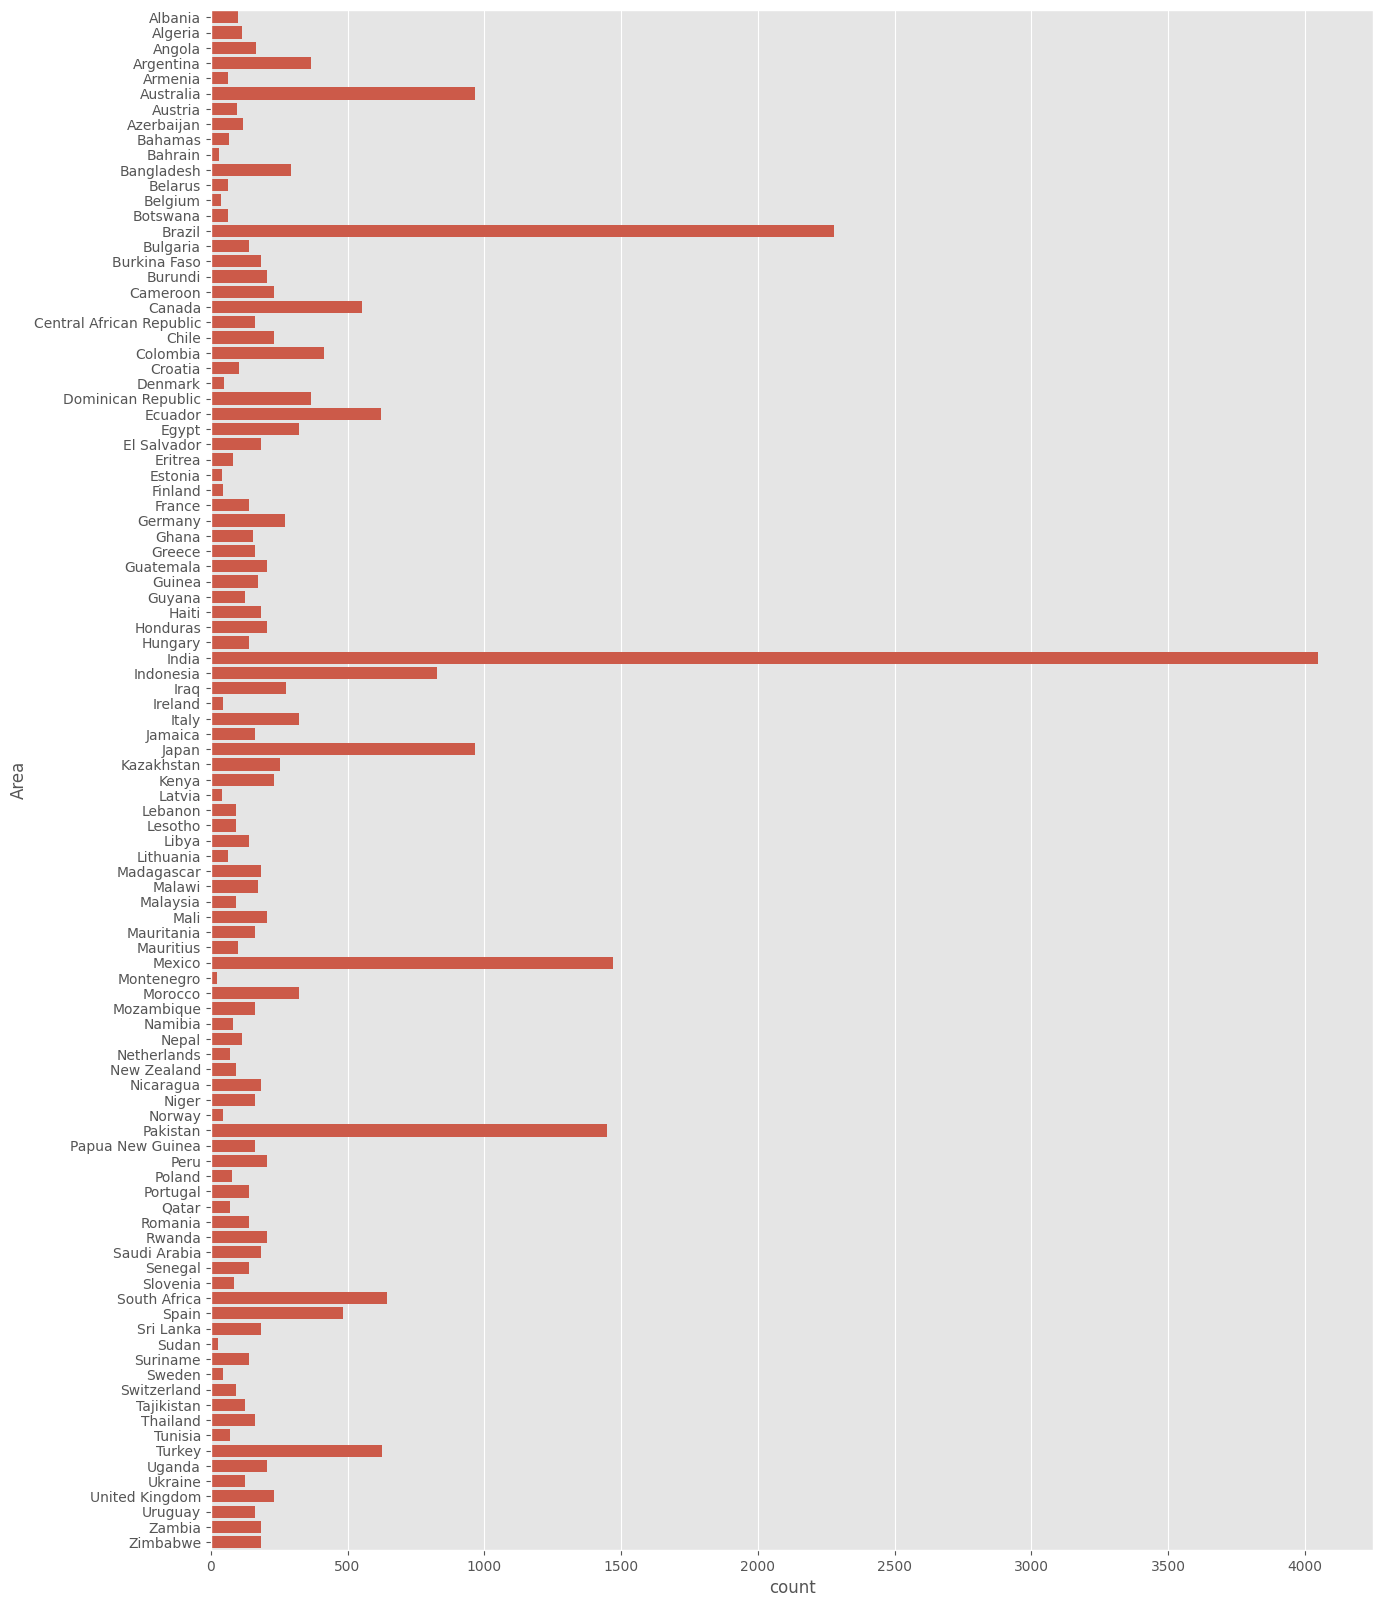

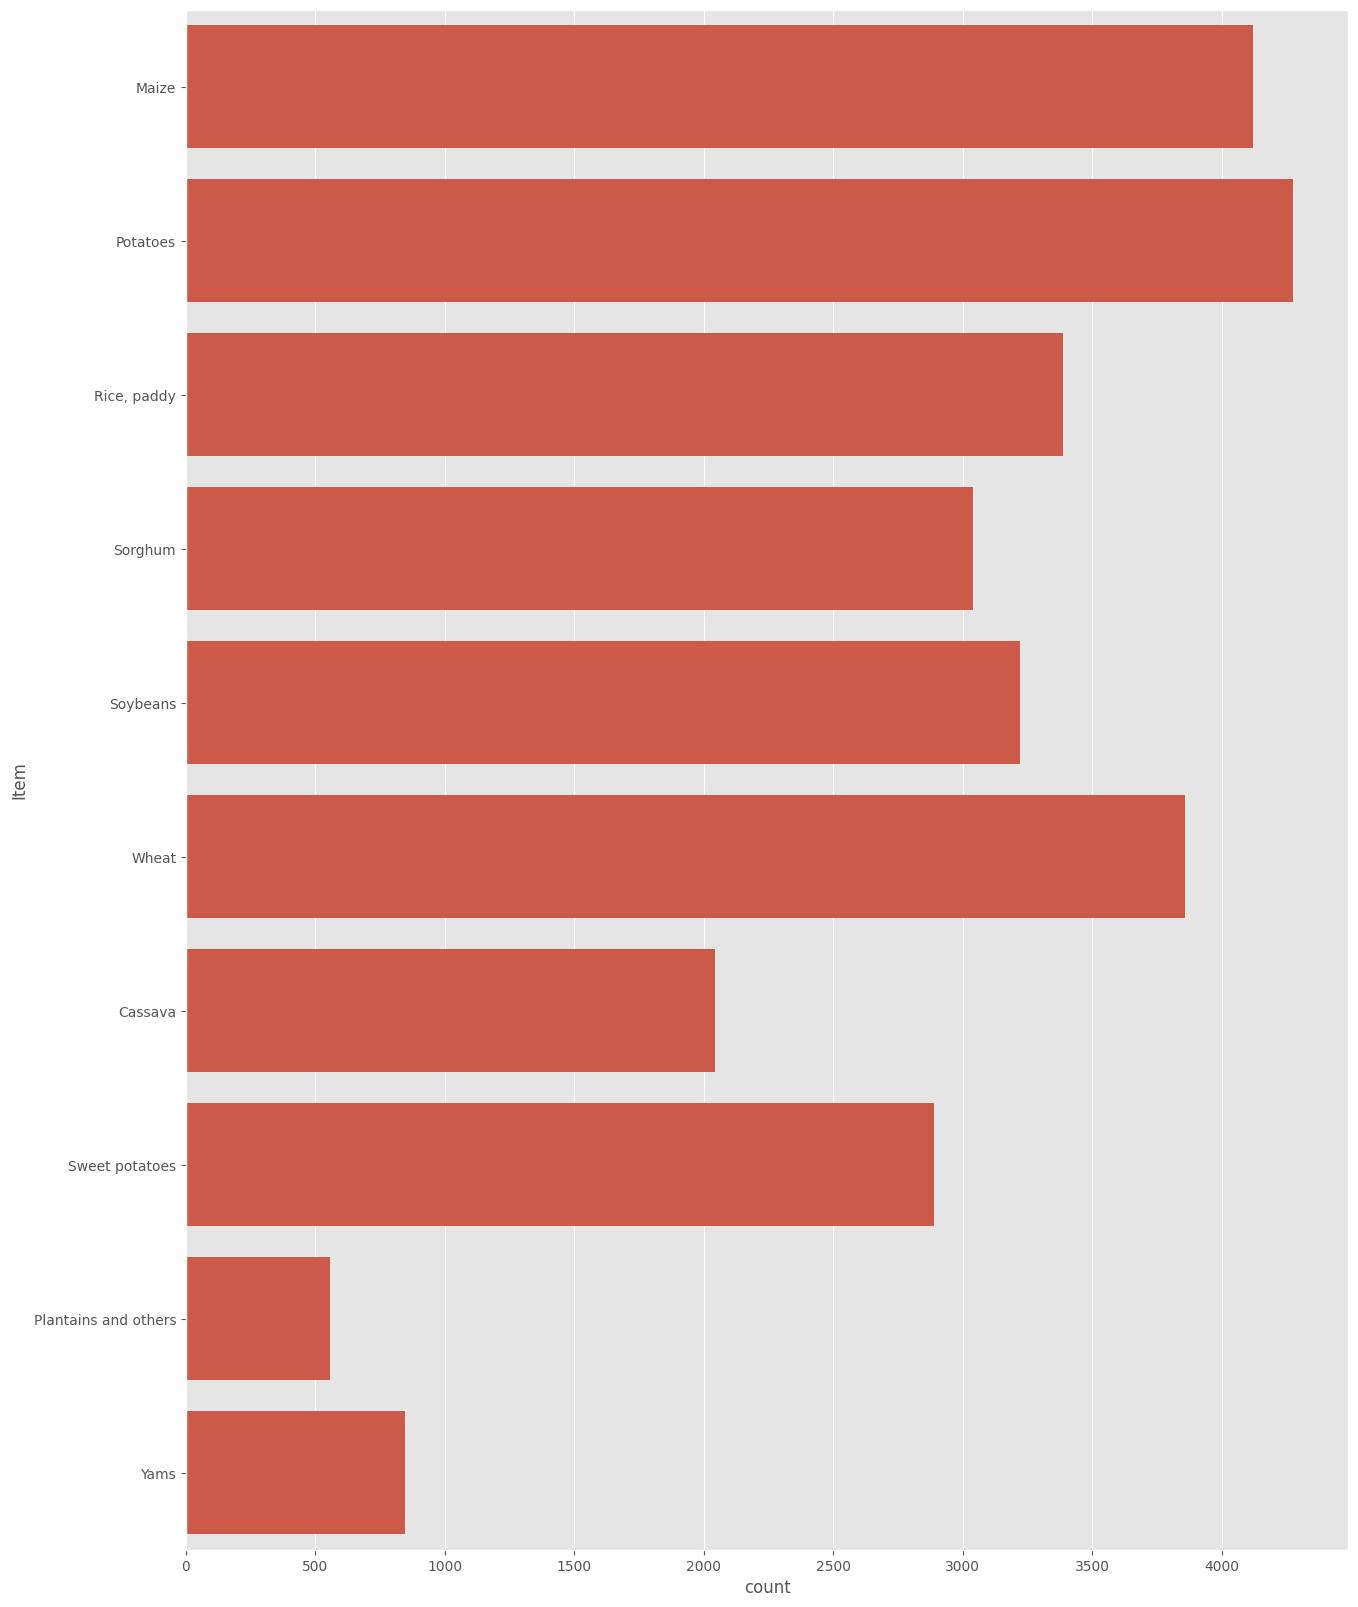

Linear Regression: MAE: 29264.171474488725 | R² Score: 0.7597401462939575
Lasso: MAE: 29240.82494919207 | R² Score: 0.7597377537313192
Ridge: MAE: 29210.70758285985 | R² Score: 0.7596487651422242
Decision Tree: MAE: 4461.155779784032 | R² Score: 0.9765306447292511
KNN: MAE: 4723.464471587892 | R² Score: 0.986029522096058
20698.0


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Load the updated dataset with carbon footprint
df = pd.read_csv("yield_df_with_carbon.csv")

# Drop unnecessary column
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Data exploration
df.info()
df.isnull().sum()
df.drop_duplicates(inplace=True)
df.shape

# Data Visualization
plt.figure(figsize=(15,20))
sns.countplot(y=df['Area'])
plt.show()

plt.figure(figsize=(15,20))
sns.countplot(y=df['Item'])
plt.show()

# Prepare features and target variable
col = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'carbon_footprint_kg_CO2_ha', 'Area', 'Item', 'hg/ha_yield']
df = df[col]

X = df.drop('hg/ha_yield', axis=1)
y = df['hg/ha_yield']

# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# Preprocessing: OneHotEncoding and StandardScaling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

ohe = OneHotEncoder(handle_unknown='ignore', drop='first')
scale = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScale', scale, [0,1,2,3,4]),  # Includes carbon footprint
        ('OneHotEncode', ohe, [5,6])  # Encodes Area and Item
    ],
    remainder='passthrough'
)

# Apply transformation
X_train_dummy = preprocessor.fit_transform(X_train)
X_test_dummy = preprocessor.transform(X_test)

# Train different models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(max_iter=5000),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(),
}

for name, md in models.items():
    md.fit(X_train_dummy, y_train)
    y_pred = md.predict(X_test_dummy)
    print(f"{name}: MAE: {mean_absolute_error(y_test, y_pred)} | R² Score: {r2_score(y_test, y_pred)}")

# Train final model
dtr = DecisionTreeRegressor()
dtr.fit(X_train_dummy, y_train)

# Updated Prediction function
def prediction(Year, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp, carbon_footprint, Area, Item):
    feature_names = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'carbon_footprint_kg_CO2_ha', 'Area', 'Item']
    features = pd.DataFrame([[Year, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp, carbon_footprint, Area, Item]], columns=feature_names)
    
    # Convert numerical values to float
    features[['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'carbon_footprint_kg_CO2_ha']] = features[['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'carbon_footprint_kg_CO2_ha']].astype(float)
    
    # Apply preprocessing
    transformed_features = preprocessor.transform(features)
    
    # Predict the yield
    predicted_yield = dtr.predict(transformed_features).reshape(-1,1)
    return predicted_yield[0][0]

# Test the new prediction function
result = prediction(1990, 1485.0, 121.0, 16.37, 2300, 'Albania', 'Maize')
print(result)

# Save the updated model and preprocessor
import pickle
pickle.dump(dtr, open("dtr_updated.pkl", "wb"))
pickle.dump(preprocessor, open("preprocessor_updated.pkl", "wb"))
